# Statistical metrics for testing against neuronal spectral noise

At the derivation notebook, we've outlined a series of test to be conducted on spectral data to differentiate between stochastic noise and structured activity. A recap:

oscillations (or any other temporally structured events) can be defined as deviations from the above specified distributions under the null hypotheses, for the 3 criteria. We can set up a series of statistical tests to compare data against the hypothesized parametric null distributions, or even use simulated white (or colored) noise signals as a way to generate distributions (as we did above) for non-parametric tests.

### for single frequencies:
1. compute summary statistics - e.g., spectral power CV, skew.
2. fit parametric distributions and test against null hypotheses stated in Criterion 1. Failure indicates significant deviations from noise.
3. optimized fitting of parametric distributions to subset of the data to maximize data likelihood (or other metric, e.g., KS test), and detect out-of-distribution samples as events (outlier detection). Can then label each data point with a probabilistic oscillation score.
4. characterize temporal structure of spectral coefficients (e.g., power autocorrelation, phase advancement/lagged coherence)

### across multiple frequencies:

5. detect correlation structure across frequencies (e.g., percentile spectrum, neighbor phase coupling, spectral PCA a la Kai Miller)
6. spectral power histograms
7. iteratively fit parametric distributions at each frequency and the power spectrum via FOOOF (Bayesian FOOOF) to separate aperiodic (and specifically, stochastic) background from structured events

---
Here, we will implement the functions to perform these tests on complex time-frequency data

0. visualization
    - ~~DONE: frequency plots~~
    - percentile spectrum
    - ~~spectral corr matrix~~
    - ~~DONE: spectral power histograms~~
    - ~~2D complex plots with fitted prob dist~~
1. summaries statistics:
    - RESAMPLE VERSIONS OF: 
    - ~~DONE:spectral power CV~~
    - ~~DONE:skew~~
    - ~~DONE:uniform dist metrics?~~
    - ~~discard outliers~~
    - ??? prune frequencies
2. fitting maximum likelihood parameters for hypothesized null-dist:
    - RESAMPLE VERSIONS OF: 
    - ~~? 2D gaussians for complex coefs.~~
    - ~~DONE: exponential dist for power~~
    - ~~DONE: circular uniform dist for phase~~
    - ~~DONE: goodness-of-fit testing (KS test)~~
    - ~~DONE: KL divergence between histogram and hypothesis~~
3. ### CHALLENGE, same as 6
4. temporal structure
    - ~~power ACF/PSD~~
    - ~~phase advancement & instantaneous freq~~
5. correlation across frequencies
    - ~~spectral PCA~~
    - ~~neighbor phase coupling~~
6. ~~DONE: see 0~~
7. Bayesian spectral parameterization
    - non-gaussian multi-class regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['image.cmap'] = 'inferno'
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)

from neurodsp import sim, plts
import numpy as np
from numpy import log10
from scipy import random, signal, stats
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA

def bootstrap(func, data, n_bs, n_samp = None, **kwargs):
    if n_samp is None: n_samp = data.shape[1]        
    stat_bs = np.array([func(data[:,random.choice(data.shape[1], n_samp, replace=True)], **kwargs) for i in range(n_bs)])
    return stat_bs.mean(0), stat_bs.std(0)

"""
Compute 1D summary features
"""
def find_freq_inds(f, f_lims):
    if f_lims is None: f_lims = (f[0], f[-1])
    return (f>=f_lims[0])&(f<=f_lims[-1])

def compute_power_phase(stft):
    return np.abs(stft)**2, np.angle(stft)
    
def compute_psd(power):
    return np.mean(power, axis=-1)

def compute_scv(power):
    return np.std(power, axis=-1)/np.mean(power, axis=-1)

def compute_skew(x):
    return stats.skew(x, axis=-1)

def ks_exp_power(power):
    # MLE for scale parameter in exponential distribution is the sample mean
    # and we constrain loc parameter to be 0 a priori
    ks_stat = np.array([stats.kstest(pw, 'expon', (0,pw.mean())) for pw in power])
    ks_stat[:,1] = log10(ks_stat[:,1]) # log the p-values for better averaging in bootstrap
    return ks_stat

def kl_unitexp_power(power, p_bins=None):
    if p_bins is None: p_bins = np.arange(0,5,0.1)
    bin_width = p_bins[1]-p_bins[0]
    ref_expdist = stats.expon(0,1).pdf(p_bins[:-1]+bin_width/2)
    return np.array([stats.entropy(np.histogram(pw/pw.mean(), p_bins)[0], ref_expdist) for pw in power])
    
def ks_uni_phase(phase):
    # test against unif ~ [-pi, pi]
    ks_stat = np.array([stats.kstest(ph, 'uniform', (-np.pi,np.pi*2)) for ph in phase])
    ks_stat[:,1] = log10(ks_stat[:,1]) # log the p-values for better averaging in bootstrap
    return ks_stat


"""
Compute cross-features
"""
def compute_power_corr(power, log_power=True):    
    if log_power:
        return np.corrcoef(log10(power))
    else: 
        return np.corrcoef(power)

def compute_coh(stft, mag_normed=True):
    """
    Compute the average vector difference between pairs of frequencies.
    The STFT is magnitude-normalized by default, such that the resulting output is a 
    square matrix of complex numbers representing the average difference vector between pair-wise frequencies. 
    The magnitude of the elements represents the degree of phase coherence, the phase represents the phase difference.
    
    When not normalized by magnitudes, the result is a magnitude-weighted coherence.
    
    Note that the resulting matrix is very similar to the complex covariance, except the cross terms are taken to be zero here.
    """
    n_freqs = stft.shape[0]
    # compute the complex conjugate product between every pair of frequency
    if mag_normed:
        # normalize by magnitude to get unit-lengthed vectors
        return np.array([(s*(stft/abs(stft)).conj()).mean(1) for s in (stft/abs(stft))])
    else:
        return np.array([(s*(stft).conj()).mean(1) for s in stft])

def fit_spectralPCA(f, power, f_lims=None, n_comp=10, log_power=True):
    f_inds = find_freq_inds(f, f_lims)
    pca = PCA(n_comp)
    if log_power:
        power_transformed = pca.fit_transform(log10(power[f_inds]).T)
    else:
        power_transformed = pca.fit(power[f_inds].T)
    return pca, f[f_inds], power_transformed

"""
Compute time features
"""
def compute_power_acf(power, nlags=20, log_power=True):
    if log_power:
        return np.array([acf(log10(p), nlags=nlags, fft=True) for p in power])
    else:
        return np.array([acf(p, nlags=nlags, fft=True) for p in power])


def compute_phase_adv(stft):
    stft_magnormed = stft/abs(stft)
    return stft_magnormed[:,1:]*stft_magnormed[:,:-1].conj()

"""
Plotting
"""
def plot_freqdomain(f, y, ys=None, f_lims=None, loglog='both', c='k', hbase=None, **kwargs):
    f_inds = find_freq_inds(f, f_lims)
    if ys is not None:
        plt.fill_between(f[f_inds], y[f_inds]-ys[f_inds], y[f_inds]+ys[f_inds], color=c, alpha=0.2)
    plt.plot(f[f_inds], y[f_inds], color=c, **kwargs)
    plt.xlim(f_lims)
    if loglog is 'both':
        plt.xscale('log'); plt.yscale('log')
    elif loglog is 'x':
        plt.xscale('log')
    elif loglog is 'y':
        plt.yscale('log')
    if hbase is not None:
        plt.axhline(hbase, color='k', linewidth=1, alpha=0.5, linestyle='--')
        
def plot_expdist_power(pw, bins=None):
    if bins is None: bins = np.arange(0,5,0.1)
    bin_width = bins[1]-bins[0]
    plt.hist(pw/pw.mean(), bins, density=True, color='k', alpha=0.5, label='rescaled data')
    plt.plot(bins+bin_width/2, stats.expon(0, 1).pdf(bins+bin_width/2), 'k.-', alpha=0.8, label='exp. dist')
    plt.legend(fancybox=False)

    
def plot_spectral_hist(f, power, log_bins=None, f_lims=None, log_x=True, plot_avg='mean'):
    f_inds = find_freq_inds(f, f_lims)
    if log_bins is None:
        log_bins = np.arange(np.floor(np.log10(power[f_inds,:].mean(1)).min()-1), np.ceil(np.log10(power[f_inds,:].mean(1)).max()+1),0.05);
        
    spect_hist = np.array([np.histogram(log10(p), log_bins, density=True)[0] for p in power[f_inds,:]])

    plt.imshow(spect_hist.T, aspect='auto', origin='lower', extent=[f_lims[0]-0.5,f_lims[1]-0.5,log_bins[0],log_bins[-1]])
    if plot_avg is 'mean':
        plt.plot(f[f_inds], log10(power.mean(1))[f_inds], '.-w', lw=1, alpha=0.5)
    if plot_avg is 'median':
        plt.plot(f[f_inds], log10(np.median(power, axis=1))[f_inds], '.-w', lw=1, alpha=0.5)

    plt.xlabel('frequency (Hz)'); plt.ylabel('log10 power'); 
    plt.xlim(f_lims); plt.ylim(log_bins[[0, -1]])
    if log_x: plt.xscale('log')
    return spect_hist

def plot_pairwise_matrix(f, mat, f_lims=None, rmv_diag=True, log_f=False, **kwargs):
    f_inds = find_freq_inds(f, f_lims)  
    plt.imshow(mat[f_inds][:,f_inds]-np.eye(sum(f_inds))*rmv_diag, aspect='auto', extent=[f_lims[0], f_lims[1], f_lims[1], f_lims[0]], **kwargs)
    if log_f:
        plt.xscale('log'); plt.yscale('log');
    plt.colorbar()
    
def plot_pca(pca, plot_comps, log_freq=False):
    plt.subplot(1,3,1)
    plt.plot(pca.explained_variance_ratio_*100, 'ok-')
    plt.xlabel('PC #'); plt.ylabel('% var. explained');

    plt.subplot(1,3,2)
    plt.plot(f_pca, pca.components_[plot_comps].T, '.-', alpha=0.5)
    if log_freq: plt.xscale('log')
    plt.xlabel('frequency (Hz)'); plt.ylabel('weight');

    plt.subplot(1,3,3)
    plt.plot(t_stft, power_transf[:,plot_comps], alpha=0.5);
    plt.xlabel('time (s)'); plt.ylabel('PC magnitude');
    plt.tight_layout()
    

def plot_freq_stack(plot_items, plot_loglog, plot_title, f_lims, hbases=None):
    if hbases is None: hbases = [None]*len(plot_items)
    for p_i, item in enumerate(plot_items):
        plt.subplot(1,4,p_i+1)
        plot_freqdomain(f_stft, item[0], item[1], f_lims=f_lims, loglog=plot_loglog[p_i], hbase=hbases[p_i])
        plt.title(plot_title[p_i])

    plt.tight_layout()
    
def plot_stft_2d(stft_query):
    s_2d = np.array([stft_query.real,stft_query.imag])
    kde2 = stats.gaussian_kde(s_2d)
    bnd = abs(s_2d).max()*1.05
    x,y = np.mgrid[-bnd:bnd:(bnd/100), -bnd:bnd:(bnd/100)]
    positions = np.vstack([x.ravel(), y.ravel()])
    z = np.reshape(kde2(positions).T, x.shape)
    circle = np.exp(1j*np.linspace(0,np.pi*2,100))*abs(stft_query).mean()

    plt.imshow(z.T, aspect='auto', extent=[x.min(), x.max(), y.max(), y.min()])
    plt.plot(circle.real, circle.imag, 'w', lw=1)
    plt.plot([0, stft_query.mean().real], [0, stft_query.mean().imag], '.-r')
    plt.plot(s_2d[0], s_2d[1], '.w', mec='k', ms=5, alpha=0.5)
    plt.axhline(0, color='w', alpha=0.2);plt.axvline(0, color='w', alpha=0.2)
    plt.tick_params(labelbottom=False, labelleft=False)

In [2]:
"""
Class
"""
class SCA:
    def __init__(self, stft, t_stft, f_stft, verbose=False):
        self.stft = stft
        self.t_stft = t_stft
        self.f_stft = f_stft
        self.thresholded = False
        self.verbose = verbose
        
        # compute power and phase
        self.power, self.phase = compute_power_phase(stft)
        return

    def thresh_by_logpow(self, criteria, thresh):
        logpow = log10(abs(self.stft)**2).sum(0)
        if criteria is 'std':
            self.discard_idx = np.where(logpow > logpow.mean()+logpow.std()*thresh)[0]
        elif criteria is 'pct':
            self.discard_idx = np.sort(np.argsort(logpow)[-int(thresh/100*len(logpow)):])

        self.keep_idx = np.setdiff1d(np.arange(len(logpow)), self.discard_idx)
        self.thresholded = True
        self.t_stft, self.t_stft_discard = self.t_stft[self.keep_idx], self.t_stft[self.discard_idx]
        self.stft, self.stft_discard = self.stft[:, self.keep_idx], self.stft[:, self.discard_idx]
        # recompute power and phase
        self.power, self.phase = compute_power_phase(self.stft)
    
    def set_bootstrap_ns(self, n_bs, n_samp):
        self.n_bs, self.n_samp = n_bs, n_samp
    
    def compute_summary(self):
        if self.verbose: print('computing bootstrapped summary metrics...')
        self.psd_m, self.psd_std  = bootstrap(compute_psd, self.power, self.n_bs, self.n_samp)
        self.scv_m, self.scv_std  = bootstrap(compute_scv, self.power, self.n_bs, self.n_samp)
        self.pwskew_m, self.pwskew_std  = bootstrap(compute_skew, self.power, self.n_bs, self.n_samp)
        self.phskew_m, self.phskew_std  = bootstrap(compute_skew, self.phase, self.n_bs, self.n_samp)
        
    def compute_ks_stats(self):
        if self.verbose: print('computing bootstrapped KS statistics...')
        self.ks_power_m, self.ks_power_std = bootstrap(ks_exp_power, self.power, self.n_bs, self.n_samp)
        self.ks_phase_m, self.ks_phase_std = bootstrap(ks_uni_phase, self.phase, self.n_bs, self.n_samp)
    
    def compute_kl_dist(self, pw_bins):
        if self.verbose: print('computing bootstrapped KL divergence...')
        self.kl_bins = pw_bins
        self.kl_m, self.kl_std = bootstrap(kl_unitexp_power, self.power, self.n_bs, self.n_samp, p_bins = pw_bins)
    
    def compute_pairwise(self, n_pc, f_lims_pca, log_power=True):
        if self.verbose: print('computing pairwise measures & PCA...')
        # power correlation across frequencies
        self.pwcorr_mat = compute_power_corr(self.power, log_power)
        # phase coherence across frequencies
        self.coh_mat = compute_coh(self.stft)
        # compute PCA
        self.pca, self.f_pca, self.power_PC = fit_spectralPCA(self.f_stft, self.power, f_lims_pca, n_pc)
        
    def compute_crosstime(self, nlags, log_power=True):
        if self.verbose: print('computing cross-time measures...')
        if self.thresholded: 
            print('warning: threshold applied, %i slices discarded, stft may be non-contiguous.'%len(self.discard_idx))
        self.power_acf = compute_power_acf(self.power, nlags, log_power)
        self.phase_adv = compute_phase_adv(self.stft)

###-----
    def plot_summary_stack(self, f_lims=(1,100), plot_loglog=['both', 'both', 'both', 'x'], hbases=None):
        plot_items = [(self.psd_m, self.psd_std),
                      (self.scv_m, self.scv_std),
                      (self.pwskew_m, self.pwskew_std),
                      (self.phskew_m, self.phskew_std)]

        plot_title = ['PSD', 'SCV', 'power skew', 'phase skew']
        plot_freq_stack(plot_items, plot_loglog, plot_title, f_lims, hbases)
    
    def plot_ks_stack(self, f_lims=(1,100), plot_loglog=['both', 'x', 'both', 'x'], hbases=None):
        plot_items = [(self.ks_power_m[:,0],self.ks_power_std[:,0]),
                      (self.ks_power_m[:,1],self.ks_power_std[:,1]),
                      (self.ks_phase_m[:,0],self.ks_phase_std[:,0]),
                      (self.ks_phase_m[:,1],self.ks_phase_std[:,1])]
        
        plot_title = ['power KS test', 'power KS p-value', 'phase KS test', 'phase KS p-value']
        plot_freq_stack(plot_items, plot_loglog, plot_title, f_lims, hbases)
    
    def plot_kl_stack(self, log_bins=None, f_lims=(1,100)):
        f_inds = np.where(find_freq_inds(self.f_stft, f_lims))[0]        
        plt.subplot(3,3,1)
        plt.imshow(log10(self.power[f_inds]), aspect='auto', extent=[self.t_stft[0],self.t_stft[-1], f_lims[-1],f_lims[0]])
        plt.tick_params(labelbottom=False); plt.title('log-power spectrogram');
        plt.xlabel('time (s)'); plt.ylabel('frequency (Hz)')
        
        plt.subplot(3,3,4)
        plot_spectral_hist(self.f_stft, self.power, log_bins, f_lims, plot_avg='mean');
        plt.title('log-power histogram'); plt.xlabel(None)
        
        plt.subplot(3,3,7)
        plot_freqdomain(self.f_stft, self.kl_m, self.kl_std, f_lims, loglog='x')
        plt.ylabel('KL-divergence'); plt.xlabel('frequency (Hz)');
        
        
        f_query = np.argsort(self.kl_m[f_inds])
        for i_p, p in enumerate([3,9,15]):
            plt.subplot(3,6,p)
            plot_expdist_power(self.power[f_inds[f_query[i_p]]], bins=self.kl_bins)
            plt.title('%.1fHz'%(self.f_stft[f_inds[f_query[i_p]]]))
            plt.tick_params(labelbottom=False, labelleft=False); plt.gca().get_legend().remove()
            plt.subplot(3,6,p+1)
            plot_stft_2d(self.stft[f_inds[f_query[i_p]]])
            
            plt.subplot(3,6,p+2)
            plot_expdist_power(self.power[f_inds[f_query[-1-i_p]]], bins=self.kl_bins)
            plt.title('%.1fHz'%(self.f_stft[f_inds[f_query[-1-i_p]]]))
            plt.tick_params(labelbottom=False, labelleft=False); plt.gca().get_legend().remove()
            plt.subplot(3,6,p+3)
            plot_stft_2d(self.stft[f_inds[f_query[-1-i_p]]])

        plt.tight_layout()
    
    def plot_pairwise_stack(self, f_lims=(1,100), plot_comps=[0,1,2], log_freq=False):
        plt.subplot(2,3,1)
        plot_pairwise_matrix(self.f_stft, self.pwcorr_mat, f_lims, rmv_diag=True, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
        plt.ylabel('frequency (Hz)')
        plt.title('log-power correlation matrix')
        plt.subplot(2,3,2)
        plot_pairwise_matrix(self.f_stft, abs(self.coh_mat), f_lims, rmv_diag=True, vmin=0, vmax=1)
        plt.title('phase-coupling magnitude')
        plt.subplot(2,3,3)
        plot_pairwise_matrix(self.f_stft, np.angle(self.coh_mat), f_lims, rmv_diag=False, vmin=-np.pi, vmax=np.pi)
        plt.title('average phase difference')
        plt.tight_layout()
        
        plt.subplot(2,3,4)
        plt.plot(self.pca.explained_variance_ratio_*100, 'ok-')
        plt.xlabel('PC #'); plt.ylabel('% var. explained');
        plt.subplot(2,3,5)
        plt.plot(self.f_pca, self.pca.components_[plot_comps].T, '.-', alpha=0.5)
        if log_freq: plt.xscale('log')
        plt.xlabel('frequency (Hz)'); plt.ylabel('weight');
        plt.subplot(2,3,6)
        plt.plot(self.t_stft, self.power_PC[:,plot_comps], alpha=0.5);
        plt.xlabel('time (s)'); plt.ylabel('PC magnitude');
        plt.tight_layout()
        
    def plot_temporal_stack(self, f_lims=(1,100)):
        f_inds = find_freq_inds(self.f_stft, f_lims)
        plt.subplot(1,3,1)
        #plt.imshow(self.power_acf[f_inds,1:], extent=[1, self.power_acf.shape[1], f_lims[-1], f_lims[0]], aspect='auto', vmin=-.5, vmax=.5, cmap='RdBu_r')
        plt.imshow(self.power_acf[f_inds,1:].T, extent=[f_lims[0], f_lims[-1], 1, self.power_acf.shape[1]], origin='lower', aspect='auto', vmin=-.5, vmax=.5, cmap='RdBu_r')
        plt.plot(self.f_stft[f_inds], (self.power_acf[f_inds,1:].mean(1)+1)*(self.power_acf.shape[1]/2), '.-k')
        plt.colorbar()
        plt.yticks([1, self.power_acf.shape[1]]); plt.ylabel('lag'); plt.xlabel('frequency'); plt.title('power autocorrelation')
        plt.subplot(1,3,2)
        plot_freqdomain(self.f_stft, abs(self.phase_adv.mean(1)), f_lims=f_lims, loglog='x')
        plt.xlabel('frequency (Hz)'); plt.title('phase advancement consistency');
        plt.subplot(1,3,3)
        plot_freqdomain(self.f_stft, np.angle(self.phase_adv.mean(1)), f_lims=f_lims, loglog='x', lw=1, marker='.')
        plt.xlabel('frequency (Hz)'); plt.title('mean phase advancement');
        plt.tight_layout()
        
    def print_report(self, filepath, f_lims=(1,100), show_figs=True):
        with PdfPages(filepath) as pages:
            fig = plt.figure(figsize=(12,3))
            self.plot_summary_stack(f_lims=f_lims, hbases=[None, 1, 2, 0])
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)
            if not show_figs: plt.close(fig)

            fig = plt.figure(figsize=(12,3))
            self.plot_ks_stack(f_lims=f_lims, hbases=[None, -2, None, -2])
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)
            if not show_figs: plt.close(fig)

            fig = plt.figure(figsize=(12,8))
            self.plot_kl_stack(f_lims=f_lims)
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)
            if not show_figs: plt.close(fig)

            fig = plt.figure(figsize=(12,7))
            self.plot_pairwise_stack(f_lims=f_lims)
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)
            if not show_figs: plt.close(fig)

            fig = plt.figure(figsize=(12,4))
            self.plot_temporal_stack(f_lims=f_lims)
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)
            if not show_figs: plt.close(fig)
        


        
# https://seaborn.pydata.org/tutorial/distributions.html        

---
### Simulated data

In [3]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                        'tau_r' : 0.002, 'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 8.2}}

sig = sim.sim_combined(n_seconds=180, fs=1000, components=components, component_variances=[1,0.4])
nperseg=1000
#f_stft, t_stft, stft = signal.stft(sig, fs=1000, window=np.ones(nperseg), nperseg=nperseg, noverlap=0, boundary=None, return_onesided=True)

# compute STFT
f_stft, t_stft, stft = signal.stft(sig, fs=1000, nperseg=nperseg, noverlap=0, boundary=None)

# # compute power and phase
# power, phase = compute_power_phase(stft)

In [4]:
sca_sim = SCA(stft, t_stft, f_stft, True)
sca_sim.thresh_by_logpow('std', 2)
sca_sim.set_bootstrap_ns(20, int(len(t_stft)/2))
sca_sim.compute_summary()
sca_sim.compute_ks_stats()

pw_bins=np.arange(0,5,0.2)
sca_sim.compute_kl_dist(pw_bins)

n_pc, f_lims_pca, log_power = 10, (1,100), True
sca_sim.compute_pairwise(n_pc, f_lims_pca, log_power)

nlags = 10
sca_sim.compute_crosstime(nlags, log_power)

computing bootstrapped summary metrics...
computing bootstrapped KS statistics...
computing bootstrapped KL divergence...
computing pairwise measures & PCA...
computing cross-time measures...


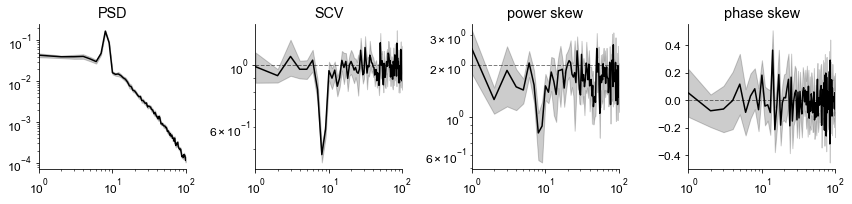

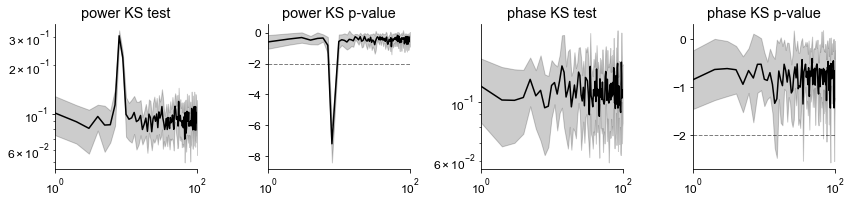

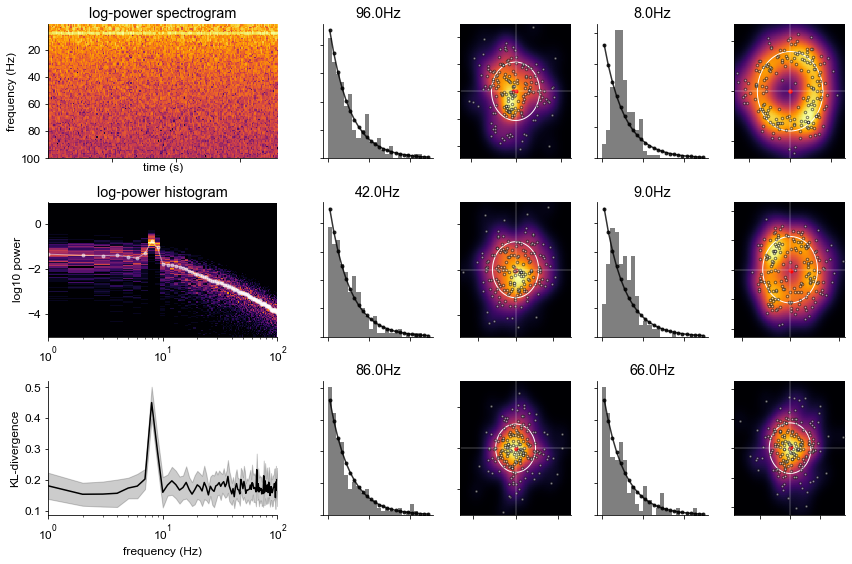

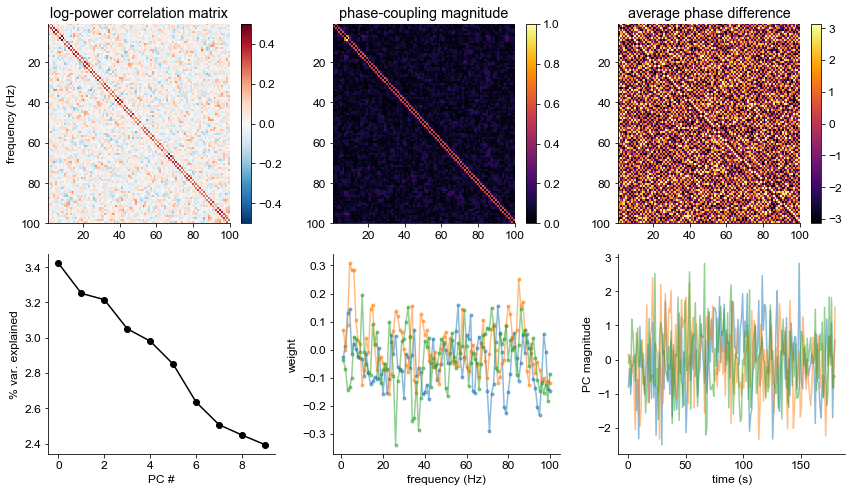

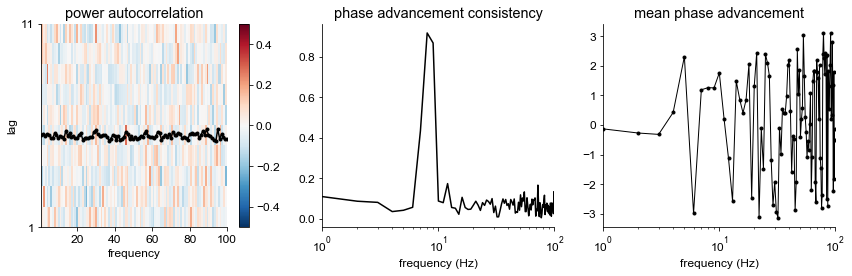

In [5]:
sca_sim.print_report('./all_report_noiseosc.pdf', (1,100), True)

# Test on chaotic signal
The classic.

In [6]:
from scipy.integrate import odeint
def lorenz(X, t, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

def sim_lorenz(T, fs, init, args):
    t = np.arange(0,T,1/fs)
    f = odeint(lorenz, init, t, args)
    x, y, z = f.T
    return x,y,z

In [7]:
# Lorenz paramters and initial conditions
T,fs = 600,500
burn_in = 10
t = np.arange(0,T,1/fs)
sigma, beta, rho = 10, 2.667, 28 # chaos values
u0, v0, w0 = np.random.randint(0,10,size=3)
x,y,z = sim_lorenz(T,fs,init=(u0, v0, w0), args=(sigma, beta, rho))

# compute STFT
f_stft, t_stft, stft = signal.stft(x[int(fs*burn_in):-int(fs*burn_in)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None, window='hann')

/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


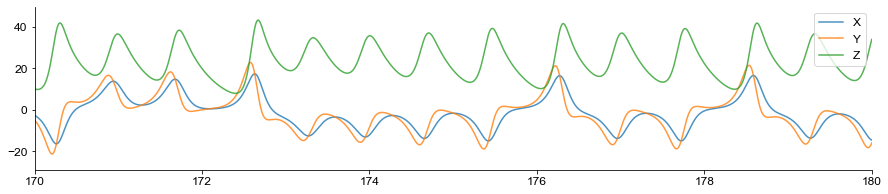

In [8]:
# plot 
plt.figure(figsize=(15,3))
plt.plot(t, x, t,y, t,z, alpha=0.8)
plt.legend(['X', 'Y', 'Z'])
plt.xlim([170, 180]);

In [9]:
t_stft[np.argsort(abs(stft[9])**2)][-10:-1]
# np.sort(abs(stft[9])**2)[-10:-1]

array([416.5, 361.5, 578.5, 441.5, 522.5, 532.5,  61.5, 514.5,  94.5])

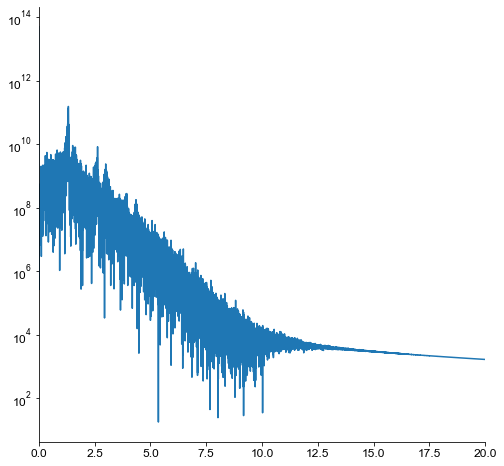

In [10]:
plt.figure(figsize=(8,8))
plt.semilogy(np.fft.rfftfreq(len(z), 1/fs),abs(np.fft.rfft(z))**2)
plt.xlim([0,20]);

In [11]:
sca_lfp = SCA(stft, t_stft, f_stft, True)
sca_lfp.thresh_by_logpow('std', 4)
sca_lfp.set_bootstrap_ns(50, int(len(t_stft)/2))
sca_lfp.compute_summary()
sca_lfp.compute_ks_stats()

pw_bins=np.arange(0,7,0.2)
sca_lfp.compute_kl_dist(pw_bins)

n_pc, f_lims_pca, log_power = 10, (1,100), True
sca_lfp.compute_pairwise(n_pc, f_lims_pca, log_power)

nlags = 20
sca_lfp.compute_crosstime(nlags, log_power)

computing bootstrapped summary metrics...
computing bootstrapped KS statistics...
computing bootstrapped KL divergence...
computing pairwise measures & PCA...
computing cross-time measures...


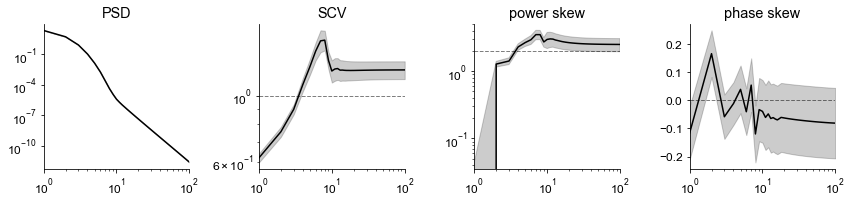

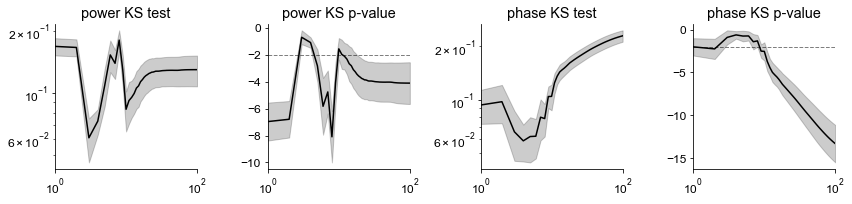

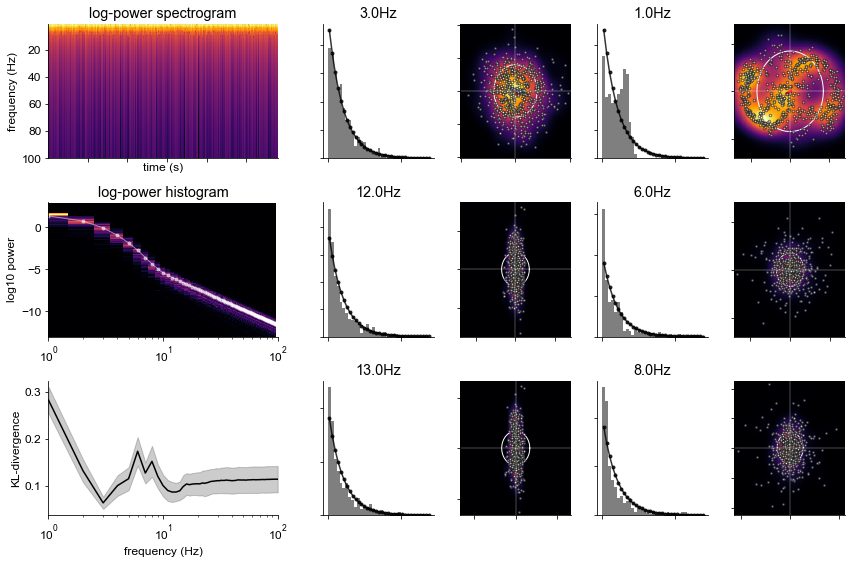

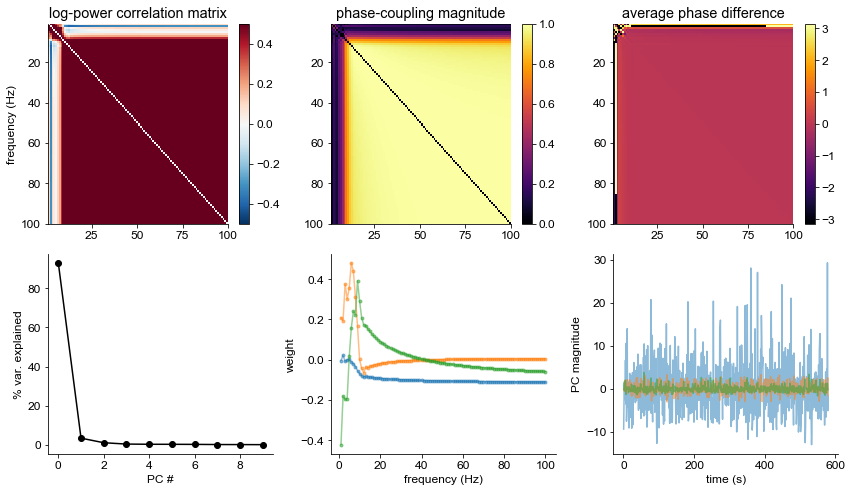

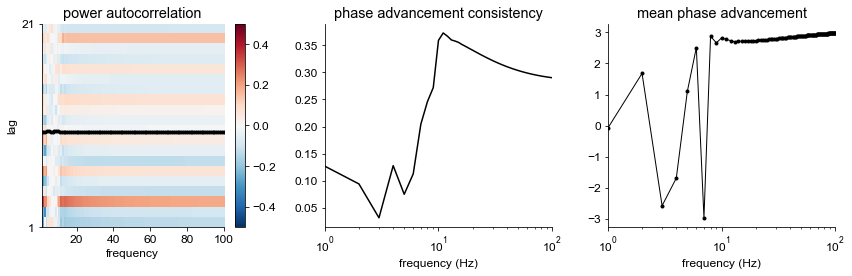

In [12]:
sca_lfp.print_report('./all_report_chaos.pdf', (1,100), True)

# Test on real data

In [13]:
from scipy import io
data = io.loadmat('/Users/rdgao/Documents/data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)

In [14]:
fs = data['srate']
lfp = data['data'][20]
# compute STFT
f_stft, t_stft, stft = signal.stft(lfp[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)

In [15]:
sca_lfp = SCA(stft, t_stft, f_stft, True)
sca_lfp.thresh_by_logpow('std', 4)
sca_lfp.set_bootstrap_ns(50, int(len(t_stft)/2))
sca_lfp.compute_summary()
sca_lfp.compute_ks_stats()

pw_bins=np.arange(0,7,0.2)
sca_lfp.compute_kl_dist(pw_bins)

n_pc, f_lims_pca, log_power = 10, (1,100), True
sca_lfp.compute_pairwise(n_pc, f_lims_pca, log_power)

nlags = 20
sca_lfp.compute_crosstime(nlags, log_power)

computing bootstrapped summary metrics...
computing bootstrapped KS statistics...
computing bootstrapped KL divergence...
computing pairwise measures & PCA...
computing cross-time measures...


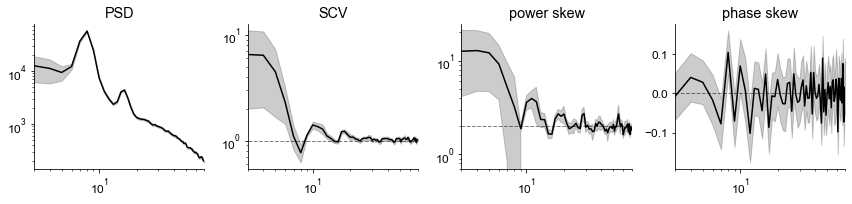

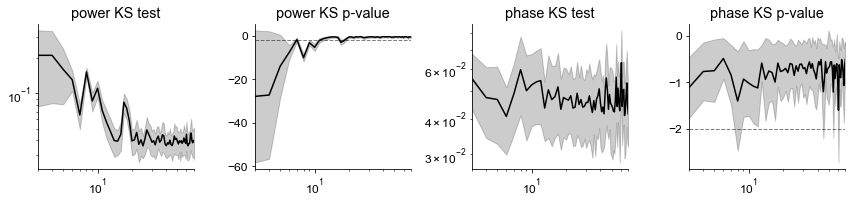

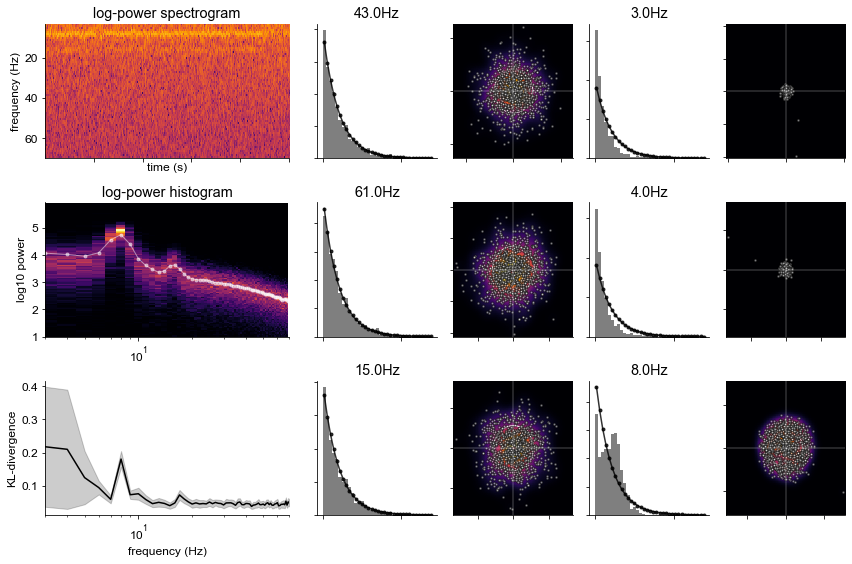

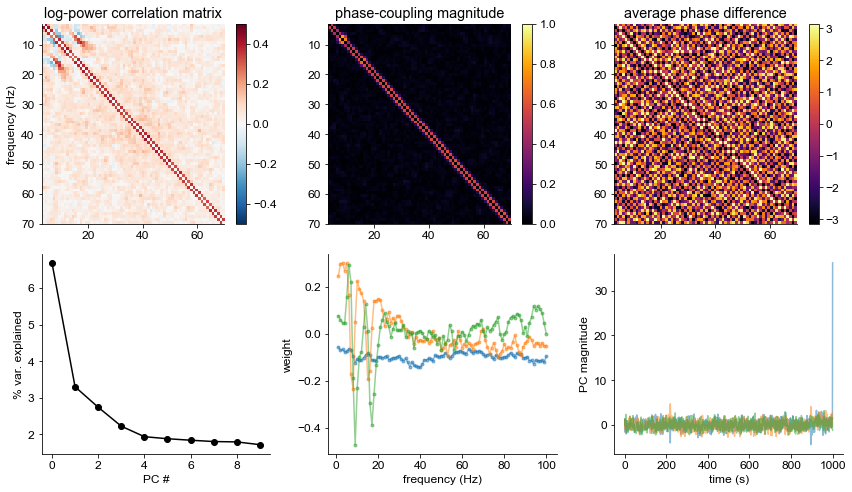

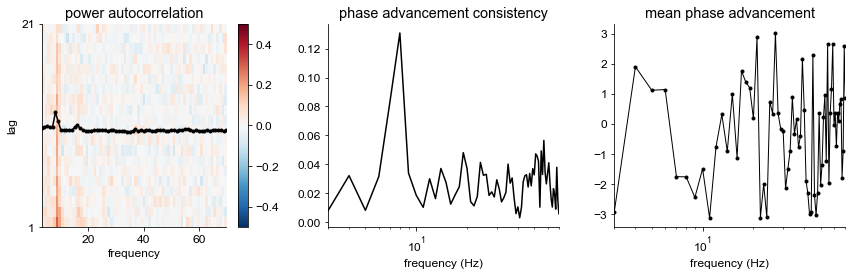

In [16]:
sca_lfp.print_report('./all_report.pdf', (3,70), True)

# scratch 

In [10]:
n_bs = 100
psd_m, psd_std  = bootstrap(compute_psd, power, n_bs)
scv_m, scv_std  = bootstrap(compute_scv, power, n_bs)
pwskew_m, pwskew_std  = bootstrap(compute_skew, power, n_bs)
phskew_m, phskew_std  = bootstrap(compute_skew, phase, n_bs)


NameError: name 'power' is not defined

In [ ]:
plot_items = [(psd_m, psd_std),(scv_m, scv_std),(pwskew_m, pwskew_std),(phskew_m, phskew_std)]
plot_loglog = ['both', 'both', 'both', 'x']
plot_title = ['PSD', 'SCV', 'power skew', 'phase skew']
plt.figure(figsize=(16,4))
for p_i, item in enumerate(plot_items):
    plt.subplot(1,4,p_i+1)
    plot_freqdomain(f_stft, item[0], item[1], f_lims=(1, 100), loglog=plot_loglog[p_i])
    plt.title(plot_title[p_i])

plt.tight_layout()


In [ ]:
power_ks_m, power_ks_std = bootstrap(ks_exp_power,power)
phase_ks_m, phase_ks_std = bootstrap(ks_uni_phase,phase)

In [ ]:
plot_items = [(power_ks_m[:,0],power_ks_std[:,0]),
              (power_ks_m[:,1],power_ks_std[:,1]),
              (phase_ks_m[:,0],phase_ks_std[:,0]),
              (phase_ks_m[:,1],phase_ks_std[:,1])]

plot_loglog = ['both', 'x', 'both', 'x']
plot_title = ['power KS test', 'power KS p-value', 'phase KS test', 'phase KS p-value']
plt.figure(figsize=(16,4))
for p_i, item in enumerate(plot_items):
    plt.subplot(1,4,p_i+1)
    plot_freqdomain(f_stft, item[0], item[1], f_lims=(1, 100), loglog=plot_loglog[p_i])
    plt.title(plot_title[p_i])

plt.tight_layout()


In [ ]:
p_bins=np.arange(0,5,0.2)
kl_m, kl_std = bootstrap(kl_unitexp_power, power, p_bins = p_bins)

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
log_bins = np.arange(-4,0,0.05)
plot_spectral_hist(f_stft, power, log_bins, f_lims=(1,100), plot_avg='mean');
plt.tight_layout()

plt.subplot(1,4,2)
plot_freqdomain(f_stft, kl_m, kl_std, f_lims=(1,100), loglog='x')
plt.ylabel('KL-divergence')

plt.subplot(1,4,3)
f_query = np.argmax(kl_m)
plot_expdist_power(power[f_query], bins=p_bins)
plt.title('%.1fHz: avg KL divergence = %.3f'%(f_stft[f_query], kl_m[f_query]))

plt.subplot(1,4,4)
f_query = np.argmin(kl_m)
plot_expdist_power(power[f_query], bins=p_bins)
plt.title('%.1fHz: avg KL divergence = %.3f'%(f_stft[f_query], kl_m[f_query]))

plt.tight_layout()

In [ ]:
# power correlation across frequencies
pwcorr_mat = compute_power_corr(power)

# phase coherence across frequencies
coh_mat = compute_coh(stft)

pca, f_pca, power_transf = fit_spectralPCA(f_stft, power, (1,200))
plot_comps = [0,1]

plt.figure(figsize=(12,4))
plot_pca(pca, plot_comps)


In [ ]:
f_lim = (1,100)
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plot_pairwise_matrix(f_stft, pwcorr_mat, f_lim, rmv_diag=True, cmap='RdBu', vmin=-0.5, vmax=0.5)
plt.ylabel('frequency')
plt.title('log-power correlation matrix')

plt.subplot(1,3,2)
plot_pairwise_matrix(f_stft, abs(coh_mat), f_lim, rmv_diag=True, vmin=0, vmax=1)
plt.title('phase-coupling magnitude')

plt.subplot(1,3,3)
plot_pairwise_matrix(f_stft, np.angle(coh_mat), f_lim, rmv_diag=False, vmin=-np.pi, vmax=np.pi)
plt.title('average phase difference')
plt.tight_layout()

In [ ]:
pw_acf = compute_power_acf(power)
phase_adv = compute_phase_adv(stft)

In [ ]:
plt.figure(figsize=(12,4))

f_inds = find_freq_inds(f_stft, (1,100))
plt.subplot(1,3,1)
plt.imshow(pw_acf[f_inds,1:], aspect='auto', vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()
plt.xlabel('lag'); plt.ylabel('frequency'); plt.title('power autocorrelation')

plt.subplot(1,3,2)
plot_freqdomain(f_stft, abs(phase_adv.mean(1)), f_lims=(1,100), loglog='x')
plt.xlabel('frequency (Hz)'); plt.title('phase advancement consistency');

plt.subplot(1,3,3)
plot_freqdomain(f_stft, np.angle(phase_adv.mean(1)), f_lims=(1,100), loglog='x', lw=1, marker='.')
plt.xlabel('frequency (Hz)'); plt.title('mean phase advancement');

plt.tight_layout()

---
# MLE fail lol

MLE for mu and sigma of multivariate Gaussian are simply sample mean and covariance

scipy multivariate normal: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

In [ ]:
#abs(stft[f]).mean()

plot_freqdomain(f_stft, psd_m, f_lims=(1,100))

for f in range (7,10):
    ring = stft[f]/abs(stft[f])*abs(stft[f]).mean()

    #plt.plot((stft[f]-ring).real, (stft[f]-ring).imag, '.');

    #plt.hist((abs(stft[f]-ring)**2))

    plt.plot(f_stft[f], (abs(stft[f]-ring)**2).mean()*2, 'ok')
    #plt.plot(f_stft[f], abs(stft[f]).std()**2*2, 'ok')

    #plt.plot(stft[f].real,stft[f].imag, '.')
    #plt.hist(abs(stft[f]),20)
    #(abs(stft[f])).std()

In [ ]:
f = 8
s_2d = np.array([stft[f].real,stft[f].imag])

# x, y = np.mgrid[-1:1:.01, -1:1:.01]*(abs(stft[f]).mean()**2)*5
# pos = np.dstack((x, y))

bnd = abs(s_2d).max()
x,y = np.mgrid[-bnd:bnd:(bnd/100), -bnd:bnd:(bnd/100)]
pos = np.dstack((x, y))

plt.figure(figsize=(6,6))
#plt.contour(x,y,stats.multivariate_normal(np.mean(s_2d, 1), np.cov(s_2d)).pdf(pos), levels=10, cmap='viridis')
plt.contour(x,y,stats.multivariate_normal(mean=[0,0],cov=(psd_m[f]/2)).pdf(pos))
plt.plot(s_2d[0],s_2d[1], '.k')
plt.plot(ring.real, ring.imag, 'r.')
plt.axhline(0, color='k', alpha=0.2);plt.axvline(0, color='k', alpha=0.2)

In [ ]:
x.max()

In [ ]:
[0, stft[f].mean().real], [0, stft[f].mean().imag]

In [ ]:

    
plt.figure(figsize=(4,4))
plot_stft_2d(stft[80])

In [ ]:
plt.figure(figsize=(4,4))
f = 80
plt.hexbin(stft[f].real,stft[f].imag, gridsize=15, marginals=True)

In [ ]:
def logl_complex(stft):
    return np.array([stats.multivariate_normal.logpdf(np.array([f.real, f.imag]).T, 
                                                      mean=[0,0], 
                                                      cov=((abs(f)**2).mean()/2)).sum() for f in stft])
logl = logl_complex(stft)
plt.figure(figsize=(4,4))
plot_freqdomain(f_stft, logl, None, f_lims=(1,100), loglog='x')

In [ ]:
n = stft.shape[1]
logl_power = np.array([stats.expon.logpdf(p, loc=0, scale=p.mean()).sum() for p in power])
plt.figure(figsize=(4,4))
plot_freqdomain(f_stft, logl_power, None, f_lims=(1,100), loglog='x')
plt.xlabel('Frequency');plt.ylabel('Total Max Log-Likelihood under Exp');
plot_freqdomain(f_stft, -n*np.log(power.mean(1))-n, None, f_lims=(1,100), loglog='x', c='r', linestyle='--')

In [ ]:
# import mne
# raw = mne.io.read_raw_fif('/Users/rdgao/Desktop/theiler.fif')
# raw.plot(scalings='auto')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f = np.arange(1,300)
k = 1000
exp1 = 3.3
exp0 = 1
lorentz = 1/(k+f**exp1)
lorentz2 = 1/((f**exp0)*(k+f**exp1))


plt.figure(figsize=(5,5))
plt.loglog(f, lorentz)
plt.loglog(f, lorentz2)